In [1]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import torch

torch.set_float32_matmul_precision("medium")  # Try "high" as well

import sys

try:
    import src
except:
    sys.path.append('../')
    import src


import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from pytorch_lightning.loggers import MLFlowLogger
import pytorch_lightning as pl
import mlflow
from typing import Tuple, List
import numpy as np

import coremltools as ct

from src.dataset import SimpleWallADE20KDataset
from src.model import WallModel
from src import config
from src.transform import get_preprocessing_transform, get_train_augmentations, get_val_augmentations, \
    get_val_augmentations_single
from src.callbacks import ModelCheckpoint, EarlyStopping, MLFlowImageLogging, LearningRateLogging

scikit-learn version 1.2.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.


In [2]:
if config.RESUME_FROM_CHECKPOINT_PATH is not None:
    print(f'Resuming from checkpoint: {config.RESUME_FROM_CHECKPOINT_PATH}')
    wall_model = WallModel.load_from_checkpoint(config.RESUME_FROM_CHECKPOINT_PATH, init_datasets=True)
else:
    # TODO: try learning without pre-trained imagenet weights (and strategy used by these Serbian dudes in WallSegmentation)
    print('Training from scratch')
    wall_model = WallModel(
        architecture=config.ARCHITECTURE,
        encoder_name=config.ENCODER,
        in_channels=3,
        out_classes=1,
        learning_rate=config.LEARNING_RATE,
        init_datasets=True,
        encoder_depth=config.ENCODER_DEPTH,
        train_size=config.TRAIN_SIZE,
        val_size=config.TRAIN_SIZE
    )
wall_model.params

Resuming from checkpoint: /home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks/epoch=159-train_loss=0.0559-val_loss=0.0692-train_dataset_iou=0.8302-val_dataset_iou=0.8128.ckpt


/home/ricardsku/miniconda3/envs/ml/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/ricardsku/miniconda3/envs/ml/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


{'input_space': 'RGB',
 'input_range': [0, 1],
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225]}

In [3]:
if config.FREEZE_ENCODER:
    print("Freezing encoder params")
    for p in wall_model.model.encoder.parameters():
        p.requires_grad = False
else:
    print('Not freezing encoder')

Not freezing encoder


In [4]:
checkpoint_callback = ModelCheckpoint(
    dirpath=os.getcwd(),
    filename='{epoch}-{train_loss:.4f}-{val_loss:.4f}-{train_dataset_iou:.4f}-{val_dataset_iou:.4f}',
    save_top_k=1,
    verbose=True,
    # monitor='val_loss',
    # mode='min',
    monitor='val_dataset_iou',
    mode='max'
)

# TODO: save both best and last checkpoint (to conitnue training)

# earlystop_callback = EarlyStopping(monitor="val_loss", patience=config.EARLYSTOP_PATIENCE)
earlystop_callback = EarlyStopping(
    # monitor="val_loss",
    # mode='min',
    monitor="val_dataset_iou",
    mode='max',
    patience=config.EARLYSTOP_PATIENCE
)

MLFLOW_EXPERIMENT_NAME = 'wall_segmentation'

# TODO: use model name from config.py
# logger = TensorBoardLogger("tb_logs", name="wall_model")

In [5]:
# TODO: Adjust parameters as described in MobileOne and DeepLab papers
# MobileOne:
#  - weight decay in early stages (probably not needed, since we do transfer learning)
#  - cosine schedule for learning rate
#  - S0 and S1 we use standard augmentation – random resized cropping and horizontal flipping.
#  - We also use EMA (Exponential Moving Average) weight averaging with decay constant of 0.9995 for training all versions of MobileOne.
#  - We use MobileOne as the backbone for a Deeplab V3 segmentation network [4] using the cvnets library [45].
#  - The VOC models were trained on the augmented Pascal VOC dataset [16] for 50 epochs following the training procedure of [45] (MobileVIT). 
#    The ADE 20k [65] models were trained using the same hyperparameters and augmentations
# DeepLab:
#  - TODO

# TODO: try this config: https://github.com/apple/ml-cvnets/blob/main/config/segmentation/ade20k/deeplabv3_mobilenetv2.yaml
# batch-size 4 per GPU (4 GPUs => effective 16 batch size)
# max image size: 1024, short side min: 256, short side max: 768
# loss: cross-entropy
# lr scheduler: cosine, max
# aspp_out_channels: 512
# aspp_rates: (12, 24, 36)
# DeepLabV3 (uses encoder, hecne DeepLabV3+)
# Backbone: ResNet50
# optimizer: SGD, weight_decay: 1e-4, no_decay_bn_filter_bias: true, momentum: 0.9

# TODO: acknowledge that we calculate metrics incorrectly - we pad all images to square form, thus effectively increasing share of 'background' class
#   Ideally we would only consider original image size during calculations.

# Considerations
# foreground (walls) and background classes are already heavily imbalanced (see data exploration).
# Adding padding and augmentations adds more 'background' area, thus increasing the imbalance. To mediate that, use ignore_index in metrics and loss functions
# To compensate for imbalance - we experimented with Focal loss and per-class loss weights (TODO)

In [6]:
NUM_IMAGES_LOG = 32

val_augmentation_fn = wall_model.val_dataset.augmentation_fn

demo_dataset = SimpleWallADE20KDataset(
    root=config.DATA_ROOT,
    length=NUM_IMAGES_LOG,
    preprocessing_fn=get_preprocessing_transform(config.ENCODER),
    augmentation_fn=val_augmentation_fn,
    mode='val'
)
demo_dataset_vis = SimpleWallADE20KDataset(
    root=config.DATA_ROOT,
    length=NUM_IMAGES_LOG,
    preprocessing_fn=None,
    augmentation_fn=val_augmentation_fn,
    mode='val'
)
demo_dataloader = DataLoader(demo_dataset, batch_size=1, shuffle=False)

imagelog_callback = MLFlowImageLogging(dataset=demo_dataset, dataset_vis=demo_dataset_vis)

In [7]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
with mlflow.start_run() as run:
    params = {
        'max_epochs': config.MAX_EPOCHS,
        'encoder_params': wall_model.params,
        'encoder_depth': wall_model.encoder_depth,
        'learning_rate': config.LEARNING_RATE,
        'batch_size': config.BATCH_SIZE,
        'val_dataset_size': len(wall_model.val_dataset),
        'train_dataset_size': len(wall_model.train_dataset),
        'architecture': config.ARCHITECTURE,
        'encoder': config.ENCODER,
        'freeze_encoder': config.FREEZE_ENCODER,
        'input_size': config.INPUT_IMAGE_SIZE,
        'checkpoint_monitor': checkpoint_callback.monitor,
        'loss': repr(wall_model.losses),
        'optimizer': type(wall_model.optimizer).__name__,
        'scheduler': type(wall_model.scheduler).__name__
    }
    if config.RESUME_FROM_CHECKPOINT_PATH is not None:
        params['resume_from_checkpoint_path'] = config.RESUME_FROM_CHECKPOINT_PATH
    for (key, value) in wall_model.optimizer.param_groups[0].items():
        if key == 'params':
            continue
        params[f'optimizer__{key}'] = str(value)
    for (key, value) in wall_model.scheduler.state_dict().items():
        params[f'scheduler__{key}'] = str(value)
    mlflow.log_params(params)

    logger = MLFlowLogger(
        MLFLOW_EXPERIMENT_NAME,
        save_dir="./mlruns",
        log_model=True,
        run_id=run.info.run_id,
    )
    
    def log_learning_rate_metric(params):
        mlflow.log_metric('learning_rate', params['learning_rate'], step=params['global_step'])
        
    lr_logging_callback = LearningRateLogging(
        log_fn=log_learning_rate_metric
    )

    trainer = pl.Trainer(
        devices=1,
        logger=logger,
        max_epochs=config.MAX_EPOCHS,
        callbacks=[
            checkpoint_callback,
            earlystop_callback,
            imagelog_callback,
            lr_logging_callback
        ],
        default_root_dir='./pl_logs',
        enable_checkpointing=True,
    )

    trainer.fit(wall_model, ckpt_path=config.RESUME_FROM_CHECKPOINT_PATH)

    mlflow.log_param('best_checkpoint', checkpoint_callback.best_model_path)
    best_checkpoint_score = checkpoint_callback.best_model_score.cpu().detach().numpy().item()
    mlflow.log_metric('best_checkpoint_score', best_checkpoint_score)

    # TODO: log best val_loss, train_loss, and other metrics

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ricardsku/miniconda3/envs/ml/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at /home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks/epoch=159-train_loss=0.0559-val_loss=0.0692-train_dataset_iou=0.8302-val_dataset_iou=0.8128.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | DeepLabV3Plus | 11.3 M
----------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.140    Total estimated model p

Sanity Checking: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/home/ricardsku/miniconda3/envs/ml/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/ricardsku/miniconda3/envs/ml/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/ricardsku/miniconda3/envs/ml/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/ricardsku/miniconda3/envs/ml/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/ricardsku/miniconda3/envs/ml/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-h84bn56u'


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 160, global step 444199: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 161, global step 446958: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 162, global step 449717: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 163, global step 452476: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 164, global step 455235: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 165, global step 457994: 'val_dataset_iou' reached 0.81314 (best 0.81314), saving model to '/home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks/epoch=165-train_loss=0.0549-val_loss=0.0681-train_dataset_iou=0.8338-val_dataset_iou=0.8131.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 166, global step 460753: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 167, global step 463512: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 168, global step 466271: 'val_dataset_iou' reached 0.81376 (best 0.81376), saving model to '/home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks/epoch=168-train_loss=0.0539-val_loss=0.0695-train_dataset_iou=0.8369-val_dataset_iou=0.8138.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 169, global step 469030: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 170, global step 471789: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 171, global step 474548: 'val_dataset_iou' reached 0.81508 (best 0.81508), saving model to '/home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks/epoch=171-train_loss=0.0534-val_loss=0.0677-train_dataset_iou=0.8380-val_dataset_iou=0.8151.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 172, global step 477307: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 173, global step 480066: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 174, global step 482825: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 175, global step 485584: 'val_dataset_iou' reached 0.81608 (best 0.81608), saving model to '/home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks/epoch=175-train_loss=0.0527-val_loss=0.0679-train_dataset_iou=0.8402-val_dataset_iou=0.8161.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 176, global step 488343: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 177, global step 491102: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 178, global step 493861: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 179, global step 496620: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 180, global step 499379: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 181, global step 502138: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 182, global step 504897: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 183, global step 507656: 'val_dataset_iou' reached 0.81636 (best 0.81636), saving model to '/home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks/epoch=183-train_loss=0.0513-val_loss=0.0699-train_dataset_iou=0.8444-val_dataset_iou=0.8164.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 184, global step 510415: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 185, global step 513174: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 186, global step 515933: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 187, global step 518692: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 188, global step 521451: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 189, global step 524210: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 190, global step 526969: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 191, global step 529728: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 192, global step 532487: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 193, global step 535246: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 194, global step 538005: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 195, global step 540764: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 196, global step 543523: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 197, global step 546282: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 198, global step 549041: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 199, global step 551800: 'val_dataset_iou' was not in top 1
`Trainer.fit` stopped: `max_epochs=200` reached.


In [8]:
# Load best weights
wall_model.load_from_checkpoint(checkpoint_callback.best_model_path)
wall_model = wall_model.eval().cpu()
print(f'Loaded {checkpoint_callback.best_model_path}')

/home/ricardsku/miniconda3/envs/ml/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/ricardsku/miniconda3/envs/ml/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Loaded /home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks/epoch=183-train_loss=0.0513-val_loss=0.0699-train_dataset_iou=0.8444-val_dataset_iou=0.8164.ckpt


In [9]:
demo_dataset = SimpleWallADE20KDataset(
    root=config.DATA_ROOT,
    length=10,
    preprocessing_fn=get_preprocessing_transform(config.ENCODER),
    augmentation_fn=get_val_augmentations(),
    mode='val'
)
demo_dataset_vis = SimpleWallADE20KDataset(
    root=config.DATA_ROOT,
    length=10,
    preprocessing_fn=None,
    augmentation_fn=get_val_augmentations(),
    mode='val'
)

In [10]:
demo_dataloader = DataLoader(demo_dataset, batch_size=1, shuffle=False)

In [11]:
def show_images(images: List[Tuple[str, np.ndarray]]):
    num_images = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        plt.axis('off')
        plt.title(name)
        plt.imshow(image)
    plt.show()

In [12]:
wall_model = wall_model.eval().cpu()

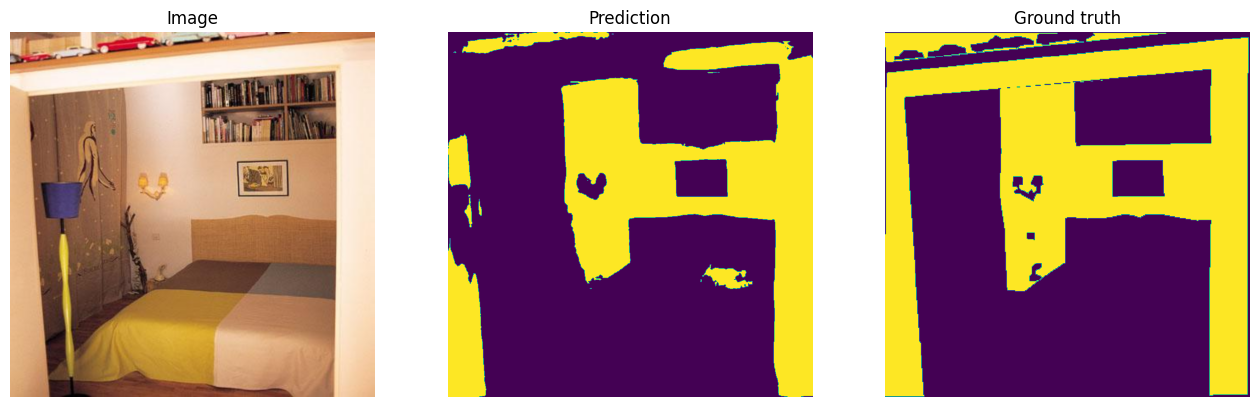

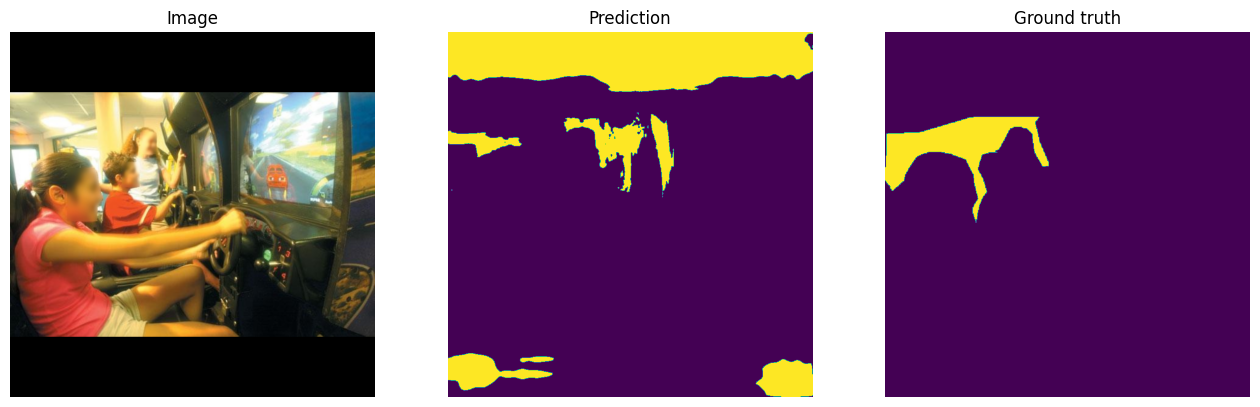

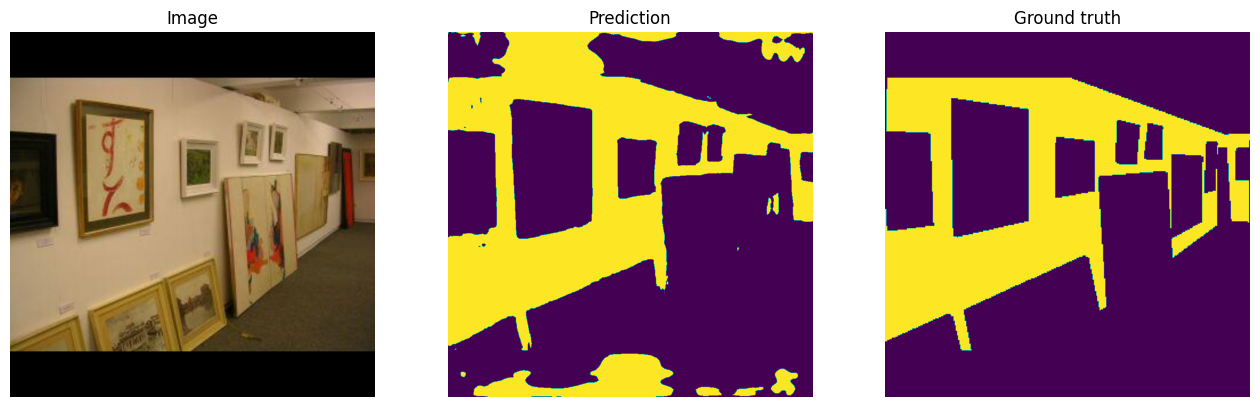

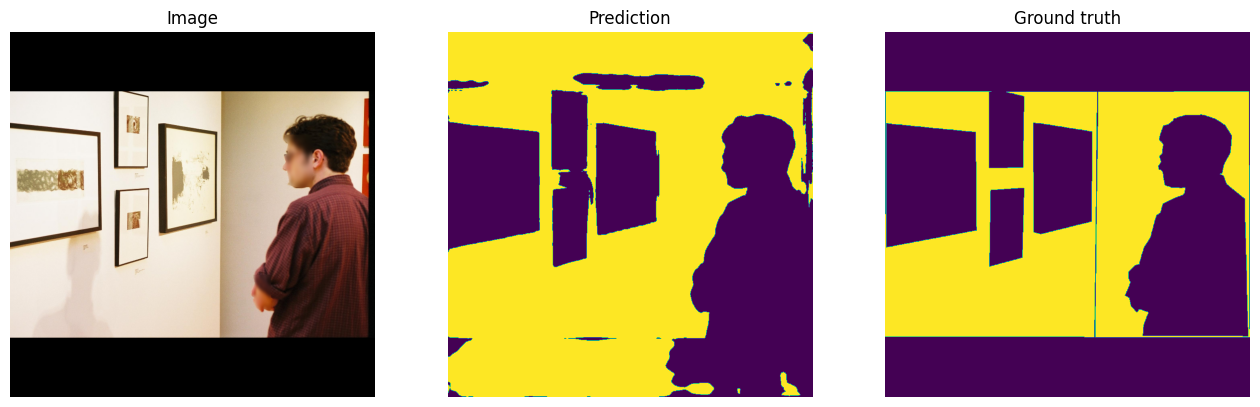

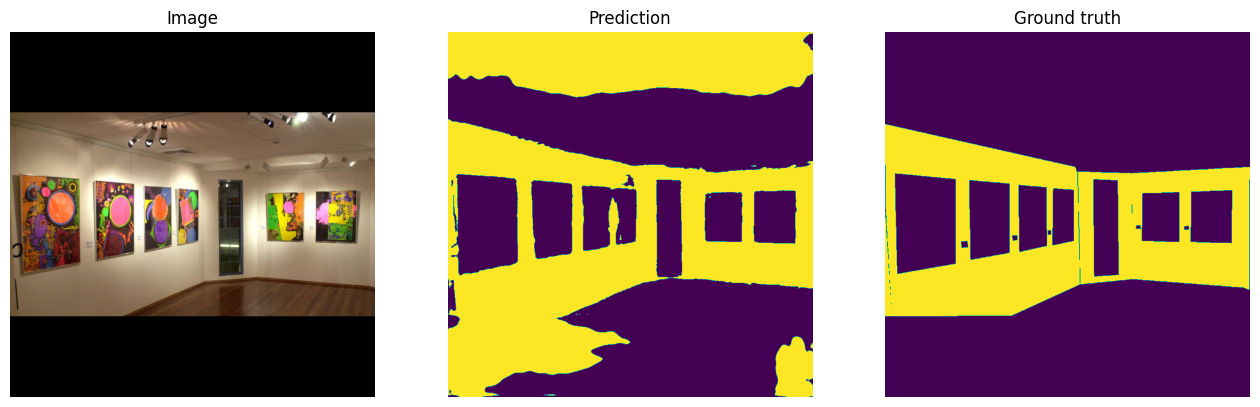

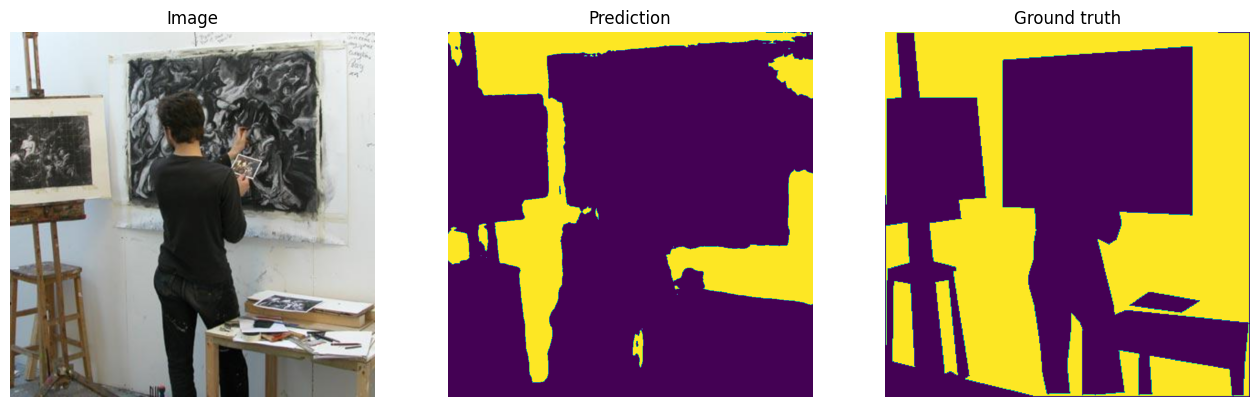

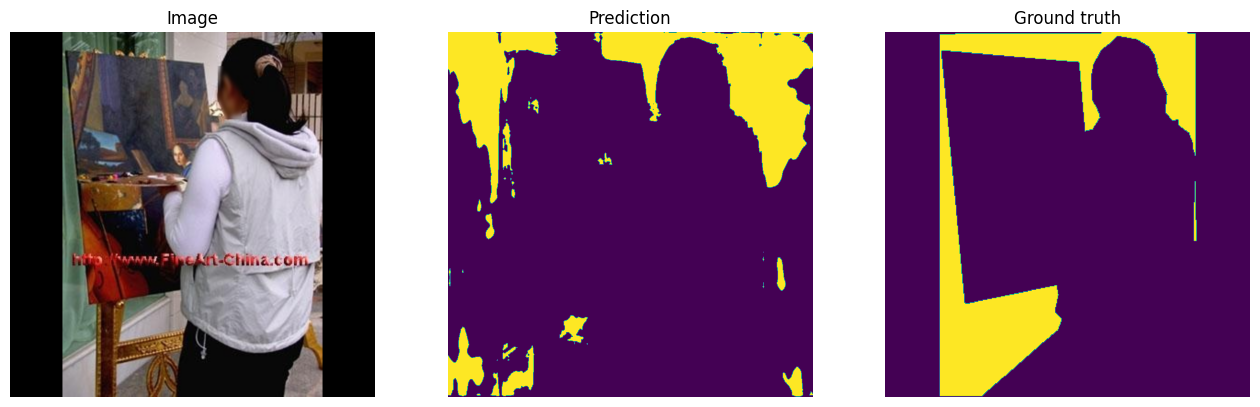

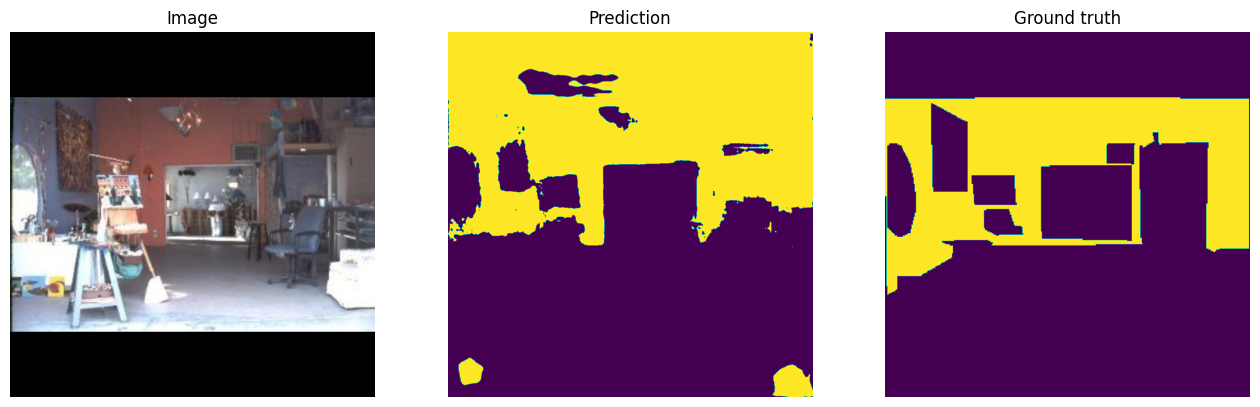

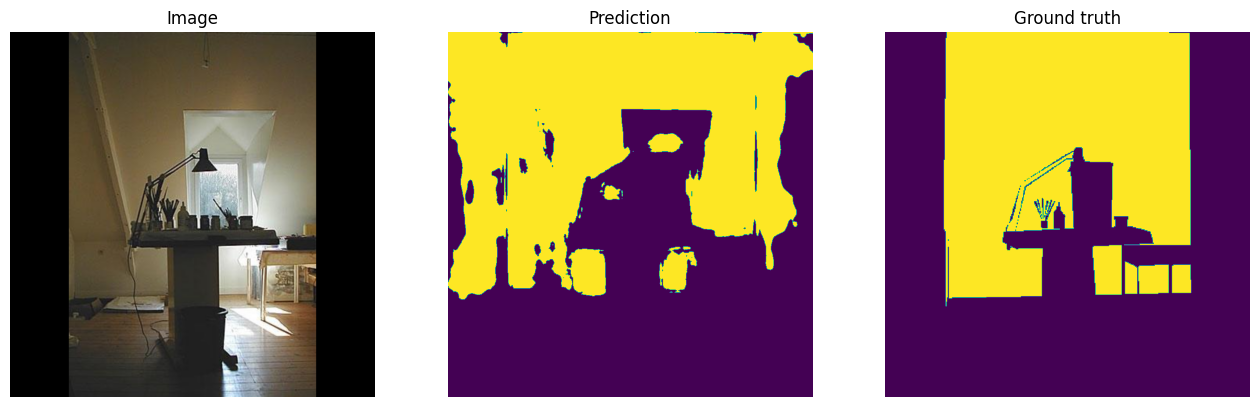

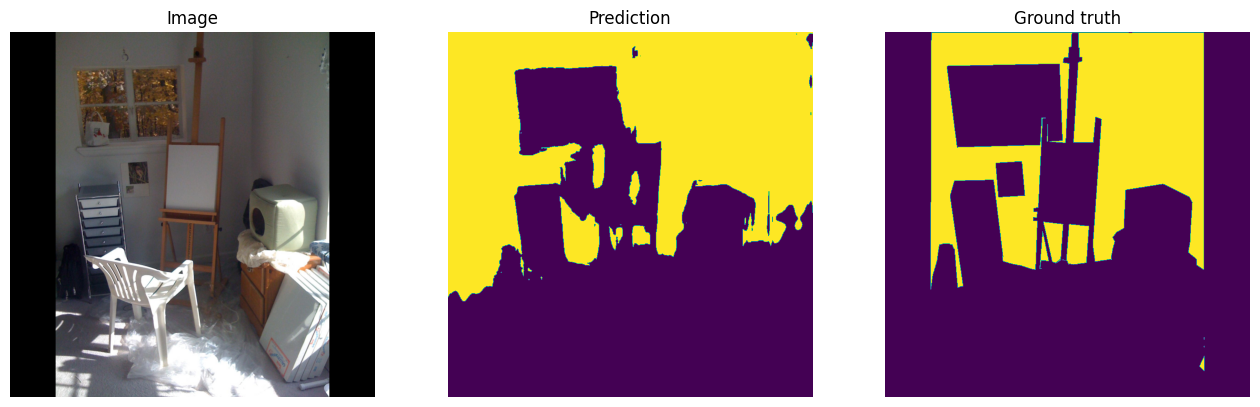

In [13]:
dataloader_iter = iter(demo_dataloader)
threshold = 0.5
for i in range(0, 10):
    image, mask = demo_dataset_vis[i]
    x, _ = next(dataloader_iter)
    # x = x.cuda()
    y = wall_model(x).cpu().detach()
    y = y.sigmoid().numpy().squeeze()
    y[y >= threshold] = 1.0
    y[y < threshold] = 0.0
    # TODO: threshold

    show_images([
        ('Image', image),
        ('Prediction', y),
        ('Ground truth', mask),
    ])

In [14]:
y[y >= 0.5] = 1.0
y[y < 0.5] = 0.0

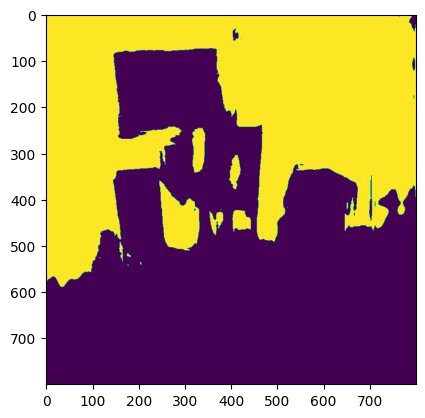

In [15]:
plt.imshow(y);